In [3]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.config import config

import logger as logging
logger = logging.init_logger(log_level=logging.INFO)

config.update("jax_enable_x64", True)
%matplotlib inline

# Model

In [2]:
from models import FCN
from neural_tangents import stax
from nngp import NNGP
import jax.numpy as jnp
from metrics import RMSE

model = FCN(
W_std=10,
b_std=5,
kernel_batch_size=0, 
device_count=-1, 
num_layers=2,
hid_dim=1, 
out_dim=1,
nonlinearity=stax.Relu
)

2022-08-14 00:57:30.361157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib


# Dataset

In [5]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 5

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

X.shape, y.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (1000, 1), (1000, 1))

# NNGP Demo

In [4]:
nngp = NNGP(model=model, train=(X, y), sigma_squared=sigma_y**2)
nngp.fit()

[2022-08-14 00:57:46,988 INFO] (nngp:16) Fitting...
[2022-08-14 00:57:46,991 INFO] (nngp:21) Fit finished in 0.00 sec


[2022-08-14 00:58:18,747 INFO] (nngp:40) Inferencing...
[2022-08-14 00:58:18,800 INFO] (nngp:47) Inference finished in 0.05 sec


1.3726473612750225


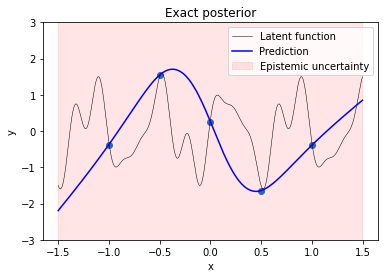

In [6]:
f_test, f_test_cov = nngp.inference(X_test)
f_test_std = np.sqrt(np.diag(f_test_cov))
print(RMSE(f_test, f_true))

plt.scatter(X, y)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Exact posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.legend()

(1000, 1) (1000, 1000)
1.3761161199378364


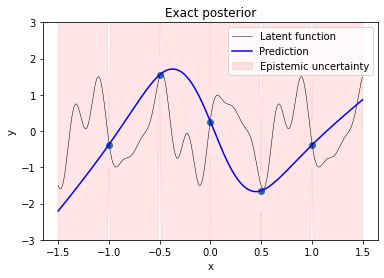

In [7]:
f_test, f_test_cov = nngp.predict_fn_(X_test)
print(f_test.shape, f_test_cov.shape)
f_test_std = np.sqrt(np.diag(f_test_cov))
print(RMSE(f_test, f_true))

plt.scatter(X, y)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Exact posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.legend()

In [7]:
nngp.log_marginal_likelihood()

DeviceArray(97.05720917, dtype=float64)

In [7]:
for i in [1, 2, 5, 10]:
    stds = jnp.array([5., 5.], dtype=jnp.float64)
    layer_num = i
    model = FCN(
                W_std = stds[0],
                b_std = stds[1],
                kernel_batch_size=0, 
                device_count=-1, 
                num_layers=layer_num,
                nonlinearity=stax.Relu
                )
    
    nngp = NNGP(model=model, train=(X, y), sigma_squared=sigma_y**2)
    nngp.fit()
    lml = nngp.log_marginal_likelihood()
    f_test, f_test_cov = nngp.predict_fn_(X_test)
    f_test_std = np.sqrt(np.diag(f_test_cov))
    rmse = RMSE(f_test, f_true)

    plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
    plt.plot(X_test, f_test, label='Prediction', c='b')
    plt.fill_between(X_test.ravel(), 
                    f_test.ravel() + 2 * f_test_std.ravel(), 
                    f_test.ravel() - 2 * f_test_std.ravel(),
                    label='Epistemic uncertainty',
                    color='r', alpha=0.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-3.0, 3.0)
    plt.legend()
    plt.savefig(f"figures/hyperparams/exact_{stds.tolist()}_{layer_num}_{lml}_{rmse}.pdf")
    plt.close()

[2022-08-12 06:44:59,591 INFO] (nngp:16) Fitting...
[2022-08-12 06:44:59,592 INFO] (nngp:21) Fit finished in 0.00 sec
[2022-08-12 06:45:00,666 INFO] (nngp:16) Fitting...
[2022-08-12 06:45:00,667 INFO] (nngp:21) Fit finished in 0.00 sec
[2022-08-12 06:45:02,225 INFO] (nngp:16) Fitting...
[2022-08-12 06:45:02,226 INFO] (nngp:21) Fit finished in 0.00 sec
[2022-08-12 06:45:05,077 INFO] (nngp:16) Fitting...
[2022-08-12 06:45:05,078 INFO] (nngp:21) Fit finished in 0.00 sec


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import gpflow
from typing import Dict
from gpflow.utilities import to_default_float

2022-08-14 01:05:26.838230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib
2022-08-14 01:05:26.838251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/vol/bitbucket/yn621/envs/individual-project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
kernel = gpflow.kernels.SquaredExponential()
Z = jnp.linspace(-1.0, 1.0, 5).reshape(-1, 1)

model = gpflow.models.SGPR(
        data=(X, y),
        kernel=kernel,
        inducing_variable=Z,
        num_latent_gps=1,
    )
    
m, v = model.predict_y(X_test)
v = jnp.sqrt(v.numpy())
m = jnp.array(m.numpy())

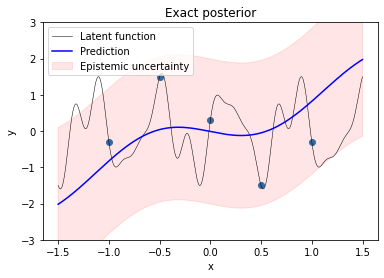

In [16]:
plt.scatter(Z, func(Z))
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, m, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 m.ravel() + 2 * v.ravel(), 
                 m.ravel() - 2 * v.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Exact posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.legend()